<a href="https://colab.research.google.com/github/yifanlu0227/MIT-6.5940/blob/main/Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MIT 6.5940 EfficientML.ai Fall 2023: Lab 1 Pruning**


This colab notebook provides code and a framework for ***Lab 1 Pruning***. You can work out your solutions here.



## Goals

In this assignment, you will practice pruning a classical neural network model to reduce both model size and latency. The goals of this assignment are as follows:

- Understand the basic concept of **pruning**
- Implement and apply **fine-grained pruning**
- Implement and apply **channel pruning**
- Get a basic understanding of performance improvement (such as speedup) from pruning
- Understand the differences and tradeoffs between these pruning approaches

## Contents

There are two main sections in this lab: ***Fine-grained Pruning*** and ***Channel Pruning***.

There are ***9*** questions in total:
- For *Fine-grained Pruning*, there are ***5*** questions (Question 1-5).
- For *Channel Pruning*, there are ***3*** questions (Question 6-8).
- Question 9 compares fine-grained pruning and channel pruning.

# Setup

First, install the required packages and download the datasets and pretrained model. Here we use CIFAR10 dataset and VGG network which is the same as what we used in the Lab 0 tutorial.

In [ ]:
print('Installing torchprofile...')
!pip install torchprofile 1>/dev/null
print('All required packages have been successfully installed!')

Installing torchprofile...
All required packages have been successfully installed!


In [2]:
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

from torchprofile import profile_macs

assert torch.cuda.is_available(), \
"The current runtime does not have CUDA support." \
"Please go to menu bar (Runtime - Change runtime type) and select GPU"

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [4]:
def download_url(url, model_dir='.', overwrite=False):
    import os, sys, ssl
    from urllib.request import urlretrieve
    ssl._create_default_https_context = ssl._create_unverified_context
    target_dir = url.split('/')[-1]
    model_dir = os.path.expanduser(model_dir)
    try:
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        model_dir = os.path.join(model_dir, target_dir)
        cached_file = model_dir
        if not os.path.exists(cached_file) or overwrite:
            sys.stderr.write('Downloading: "{}" to {}\n'.format(url, cached_file))
            urlretrieve(url, cached_file)
        return cached_file
    except Exception as e:
        # remove lock file so download can be executed next time.
        os.remove(os.path.join(model_dir, 'download.lock'))
        sys.stderr.write('Failed to download from url %s' % url + '\n' + str(e) + '\n')
        return None

In [5]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

In [6]:
def calculate_accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k.
    """
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res
  
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()
  top1 = 0.0
  top5 = 0.0
  total = 0
  device = 'cuda'
  with torch.no_grad():
      for inputs, targets in dataloader:
          inputs, targets = inputs.to(device), targets.to(device)
          outputs = model(inputs)
          prec1, prec5 = calculate_accuracy(outputs, targets, topk=(1, 5)) #use local accuracy function
          top1 += prec1.item() * inputs.size(0)
          top5 += prec5.item() * inputs.size(0)
          total += inputs.size(0)
  return top1 / total, top5 / total

Helper Functions (Flops, Model Size calculation, etc.)

In [7]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

*Define* misc functions for verification.

Load the pretrained model and the CIFAR-10 dataset.

In [8]:
from itertools import islice

class FreshBatchLoader:
    def __init__(self, dataset, batch_size=256, num_workers=1, pin_memory=True, max_batches=100):
        self.dataset = dataset
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.pin_memory = pin_memory
        self.max_batches = max_batches

    def __iter__(self):
        loader = torch.utils.data.DataLoader(
            self.dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory
        )
        return islice(iter(loader), self.max_batches)

    def __len__(self):
        return self.max_batches

In [9]:
import os
import torch
from torchvision.datasets import ImageFolder, CIFAR10, CIFAR100
from torchvision.transforms import (
    RandomResizedCrop, RandomHorizontalFlip, ToTensor, Normalize,
    Resize, CenterCrop, Compose
)

data_root = '/srv/datasets/'
traindir = os.path.join(data_root, 'train')
valdir = os.path.join(data_root, 'val')

# preprocessing
input_size = 224
imagenet_tran_train = [
    RandomResizedCrop(input_size, scale=(0.2, 1.0)),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]
imagenet_tran_test = [
    Resize(int(input_size / 0.875)),
    CenterCrop(input_size),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]

# Dataset created once
train_dataset = ImageFolder(traindir, Compose(imagenet_tran_train))
val_dataset = ImageFolder(valdir, Compose(imagenet_tran_train))

# Use fresh batch loader
limited_train_loader = FreshBatchLoader(train_dataset, batch_size=256, max_batches=100)
limited_val_loader = FreshBatchLoader(val_dataset, batch_size=256, max_batches=100)

val_loader = torch.utils.data.DataLoader(
    ImageFolder(valdir, Compose(imagenet_tran_test)),
    batch_size=256, shuffle=False,
    num_workers=1, pin_memory=True)

n_class = 1000

dataloader = {
    'train': limited_train_loader,
    'val': val_loader
}


# Let's First Evaluate the Accuracy and Model Size of Dense Model

Neural networks have become ubiquitous in many applications. Here we have loaded a pretrained VGG model for classifying images in ImageNet dataset.

Let's first evaluate the accuracy and model size of this model.

In [10]:
%cd ../..
!ls

/home/arun/Desktop/Pruning-and-Mixed-Precision-Quantization-of-Neural-Networks
cifar10  data  imagenet  lib  model.py	models	__pycache__  q_ch.py  utils.py


/home/arun/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [12]:
from torchvision.models import resnet50, ResNet50_Weights

model = resnet50(ResNet50_Weights).cuda()
top1, top5 = evaluate(model, dataloader['val'])
dense_model_size = get_model_size(model)
print(f"dense model has accuracy={top1:.2f}% {top5:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")

/usr/lib/python3.10/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/lib/python3.10/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


dense model has accuracy=76.15% 92.87%
dense model has size=97.49 MiB


While large neural networks are very powerful, their size consumes considerable storage, memory bandwidth, and computational resources.
As we can see from the results above, a model for the task as simple as classifying $32\times32$ images into 10 classes can be as large as 35 MiB.
For embedded mobile applications, these resource demands become prohibitive.

Therefore, neural network pruning is exploited to facilitates storage and transmission of mobile applications incorporating DNNs.

The goal of pruning is to reduce the model size while maintaining the accuracy.

# Let's see the distribution of weight values

Before we jump into pruning, let's see the distribution of weight values in the dense model.

IndexError: index 21 is out of bounds for axis 0 with size 21

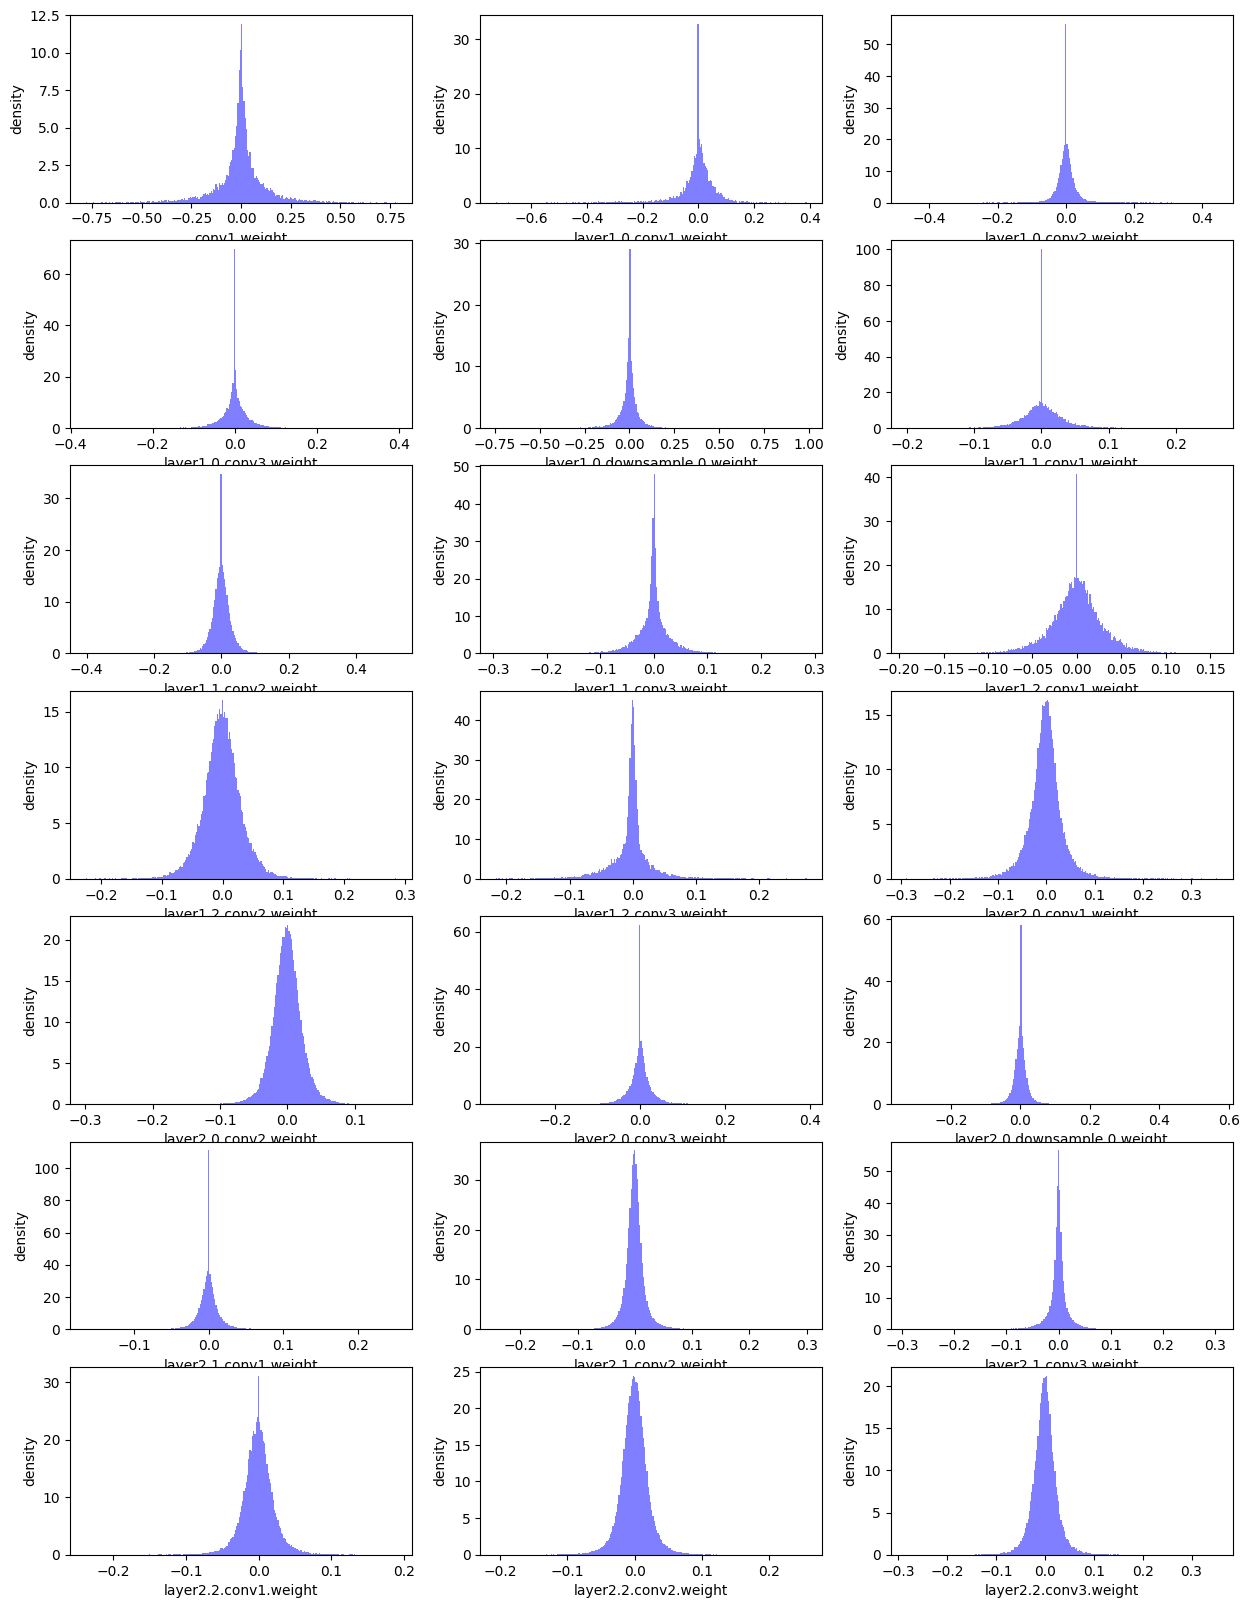

In [ ]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(7, 3, figsize=(15, 20))   # num_layers = 54 for resnet50, 18 for resnet18, 64 for mobilenet, 16 for vgg
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()
    
plot_weight_distribution(model)

## Question 1 (10 pts)

Please answer the following questions using the information in the above histograms of weights.


### Question 1.1 (5 pts)

What are the common characteristics of the weight distribution in the different layers?

**Your Answer:** A lot of 0.

### Question 1.2  (5 pts)

How do these characteristics help pruning?

**Your Answer:** We can remove these 0.

# Fine-grained Pruning

In this section, we will implement and perform fine-grained pruning.

Fine-grained pruning removes the synapses with lowest importance. The weight tensor $W$ will become sparse after fine-grained pruning, which can be described with **sparsity**:

> $\mathrm{sparsity} := \#\mathrm{Zeros} / \#W = 1 - \#\mathrm{Nonzeros} / \#W$

where $\#W$ is the number of elements in $W$.

In practice, given the target sparsity $s$, the weight tensor $W$ is multiplied with a binary mask $M$ to disregard removed weight:

> $v_{\mathrm{thr}} = \texttt{kthvalue}(Importance, \#W \cdot s)$
>
> $M = Importance > v_{\mathrm{thr}}$
>
> $W = W \cdot M$

where $Importance$ is importance tensor with the same shape of $W$, $\texttt{kthvalue}(X, k)$ finds the $k$-th smallest value of tensor $X$, $v_{\mathrm{thr}}$ is the threshold value.

## Magnitude-based Pruning

For fine-grained pruning, a widely-used importance is the magnitude of weight value, *i.e.*,

$Importance=|W|$

This is known as **Magnitude-based Pruning** (see [Learning both Weights and Connections for Efficient
Neural Networks](https://arxiv.org/pdf/1506.02626.pdf)).

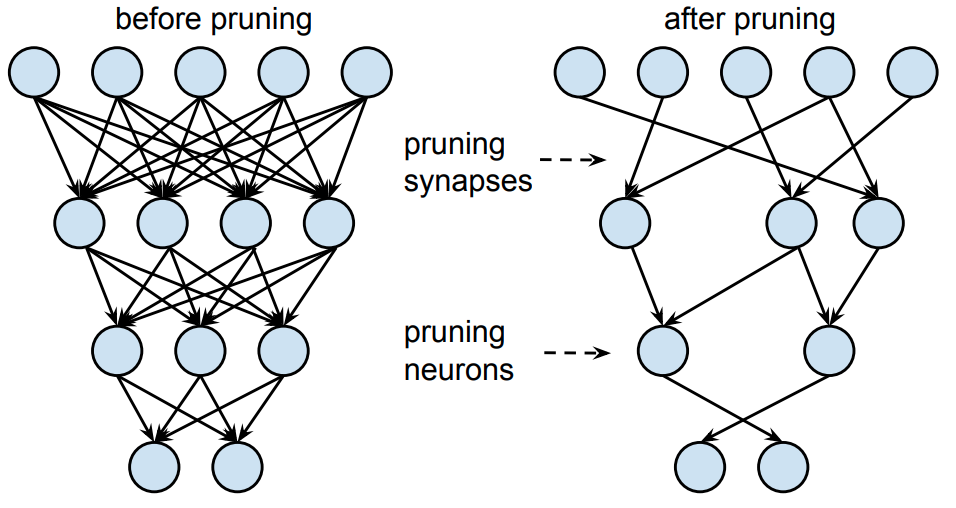

### Question 2 (15 pts)

Please complete the following magnitude-based fine-grained pruning function.

**Hint**:
*   In step 1, we calculate the number of zeros (`num_zeros`) after pruning. Note that `num_zeros` should be an integer. You could use either `round()` or `int()` to convert a floating number into an integer. Here we use `round()`.
*   In step 2, we calculate the `importance` of weight tensor. Pytorch provides [`torch.abs()`](https://pytorch.org/docs/stable/generated/torch.abs.html#torch.abs), [`torch.Tensor.abs()`](https://pytorch.org/docs/stable/generated/torch.Tensor.abs.html#torch.Tensor.abs), [`torch.Tensor.abs_()`](https://pytorch.org/docs/stable/generated/torch.Tensor.abs_.html) APIs.
*   In step 3, we calculate the pruning `threshold` so that all synapses with importance smaller than `threshold` will be removed. Pytorch provides [`torch.kthvalue()`](https://pytorch.org/docs/stable/generated/torch.kthvalue.html), [`torch.Tensor.kthvalue()`](https://pytorch.org/docs/stable/generated/torch.Tensor.kthvalue.html), [`torch.topk()`](https://pytorch.org/docs/stable/generated/torch.topk.html) APIs.
*   In step 4, we calculate the pruning `mask` based on the `threshold`. **1** in the `mask` indicates the synapse will be kept, and **0** in the `mask` indicates the synapse will be removed. `mask = importance > threshold`. Pytorch provides [`torch.gt()`](https://pytorch.org/docs/stable/generated/torch.gt.html?highlight=torch%20gt#torch.gt) API.

In [13]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()

    ##################### YOUR CODE STARTS HERE #####################
    # Step 1: calculate the #zeros (please use round())
    num_zeros = round(num_elements * sparsity)
    # Step 2: calculate the importance of weight
    importance = torch.abs(tensor)
    # Step 3: calculate the pruning threshold
    threshold = torch.kthvalue(importance.flatten(), num_zeros)[0]
    # Step 4: get binary mask (1 for nonzeros, 0 for zeros)
    mask = importance > threshold
    ##################### YOUR CODE ENDS HERE #######################

    # Step 5: apply mask to prune the tensor
    tensor.mul_(mask)

    return mask

Let's verify the functionality of defined fine-grained pruning by applying the function above on a dummy tensor.

### Question 3 (5 pts)

The last cell plots the tensor before and after pruning. Nonzeros are rendered in blue while zeros are rendered in gray. Please modify the value of `target_sparsity` in the following code cell so that there are only 10 nonzeros in the sparse tensor after pruning.

We now wrap the fine-grained pruning function into a class for pruning the whole model. In class `FineGrainedPruner`, we have to keep a record of the pruning masks so that we could apply the masks whenever the model weights change to make sure the model keep sparse all the time.

In [14]:
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks

## Sensitivity Scan


Different layers contribute differently to the model performance. It is challenging to decide the proper sparsity for each layer. A widely used approach is sensitivity scan.

During the sensitivity scan, at each time, we will only prune one layer to see the accuracy degradation. By scanning different sparsities, we could draw the sensitivity curve (i.e., accuracy vs. sparsity) of the corresponding layer.

Here is an example figure for sensitivity curves. The x-axis is the sparsity or the percentage of #parameters dropped (*i.e.*, sparsity). The y-axis is the validation accuracy. (This is Figure 6 in [Learning both Weights and Connections for Efficient
Neural Networks](https://arxiv.org/pdf/1506.02626.pdf))


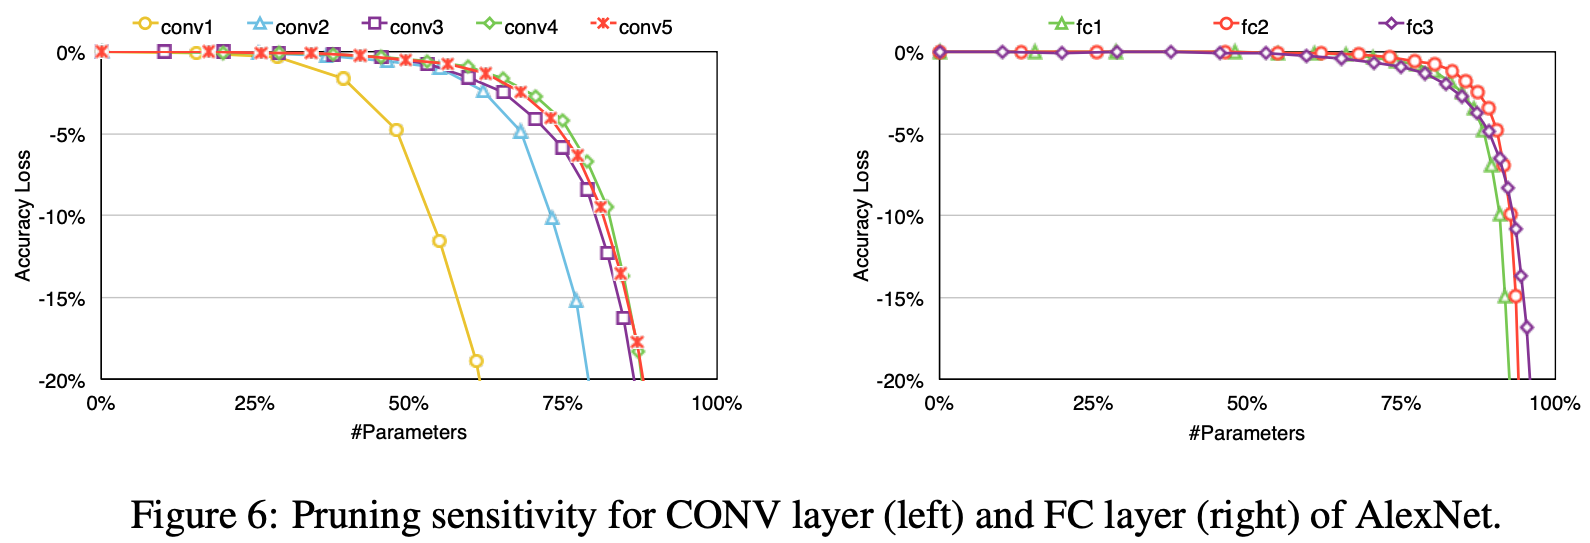

The following code cell defines the sensitivity scan function that returns the sparsities scanned, and a list of accuracies for each weight to be pruned.

### Question 4 (15 pts)

Please answer the following questions using the information in the above sensitivity curves.

#### Question 4.1 (5 pts)

What's the relationship between pruning sparsity and model accuracy? (*i.e.*, does accuracy increase or decrease when sparsity becomes higher?)

**Your Answer:** sparsity increases, the model accuracy decreases.

#### Question 4.2 (5 pts)

Do all the layers have the same sensitivity?

**Your Answer:** No

#### Question 4.3 (5 pts)

Which layer is the most sensitive to the pruning sparsity?

**Your Answer:** features.conv0.weight

## \#Parameters of each layer
In addition to accuracy, the number of each layer's parameters also affects the decision on sparsity selection. Layers with more #parameters require larger sparsities.

Please run the following code cell to plot the distribution of #parameters in the whole model.

{'conv1.weight': 9408, 'layer1.0.conv1.weight': 4096, 'layer1.0.conv2.weight': 36864, 'layer1.0.conv3.weight': 16384, 'layer1.0.downsample.0.weight': 16384, 'layer1.1.conv1.weight': 16384, 'layer1.1.conv2.weight': 36864, 'layer1.1.conv3.weight': 16384, 'layer1.2.conv1.weight': 16384, 'layer1.2.conv2.weight': 36864, 'layer1.2.conv3.weight': 16384, 'layer2.0.conv1.weight': 32768, 'layer2.0.conv2.weight': 147456, 'layer2.0.conv3.weight': 65536, 'layer2.0.downsample.0.weight': 131072, 'layer2.1.conv1.weight': 65536, 'layer2.1.conv2.weight': 147456, 'layer2.1.conv3.weight': 65536, 'layer2.2.conv1.weight': 65536, 'layer2.2.conv2.weight': 147456, 'layer2.2.conv3.weight': 65536, 'layer2.3.conv1.weight': 65536, 'layer2.3.conv2.weight': 147456, 'layer2.3.conv3.weight': 65536, 'layer3.0.conv1.weight': 131072, 'layer3.0.conv2.weight': 589824, 'layer3.0.conv3.weight': 262144, 'layer3.0.downsample.0.weight': 524288, 'layer3.1.conv1.weight': 262144, 'layer3.1.conv2.weight': 589824, 'layer3.1.conv3.we

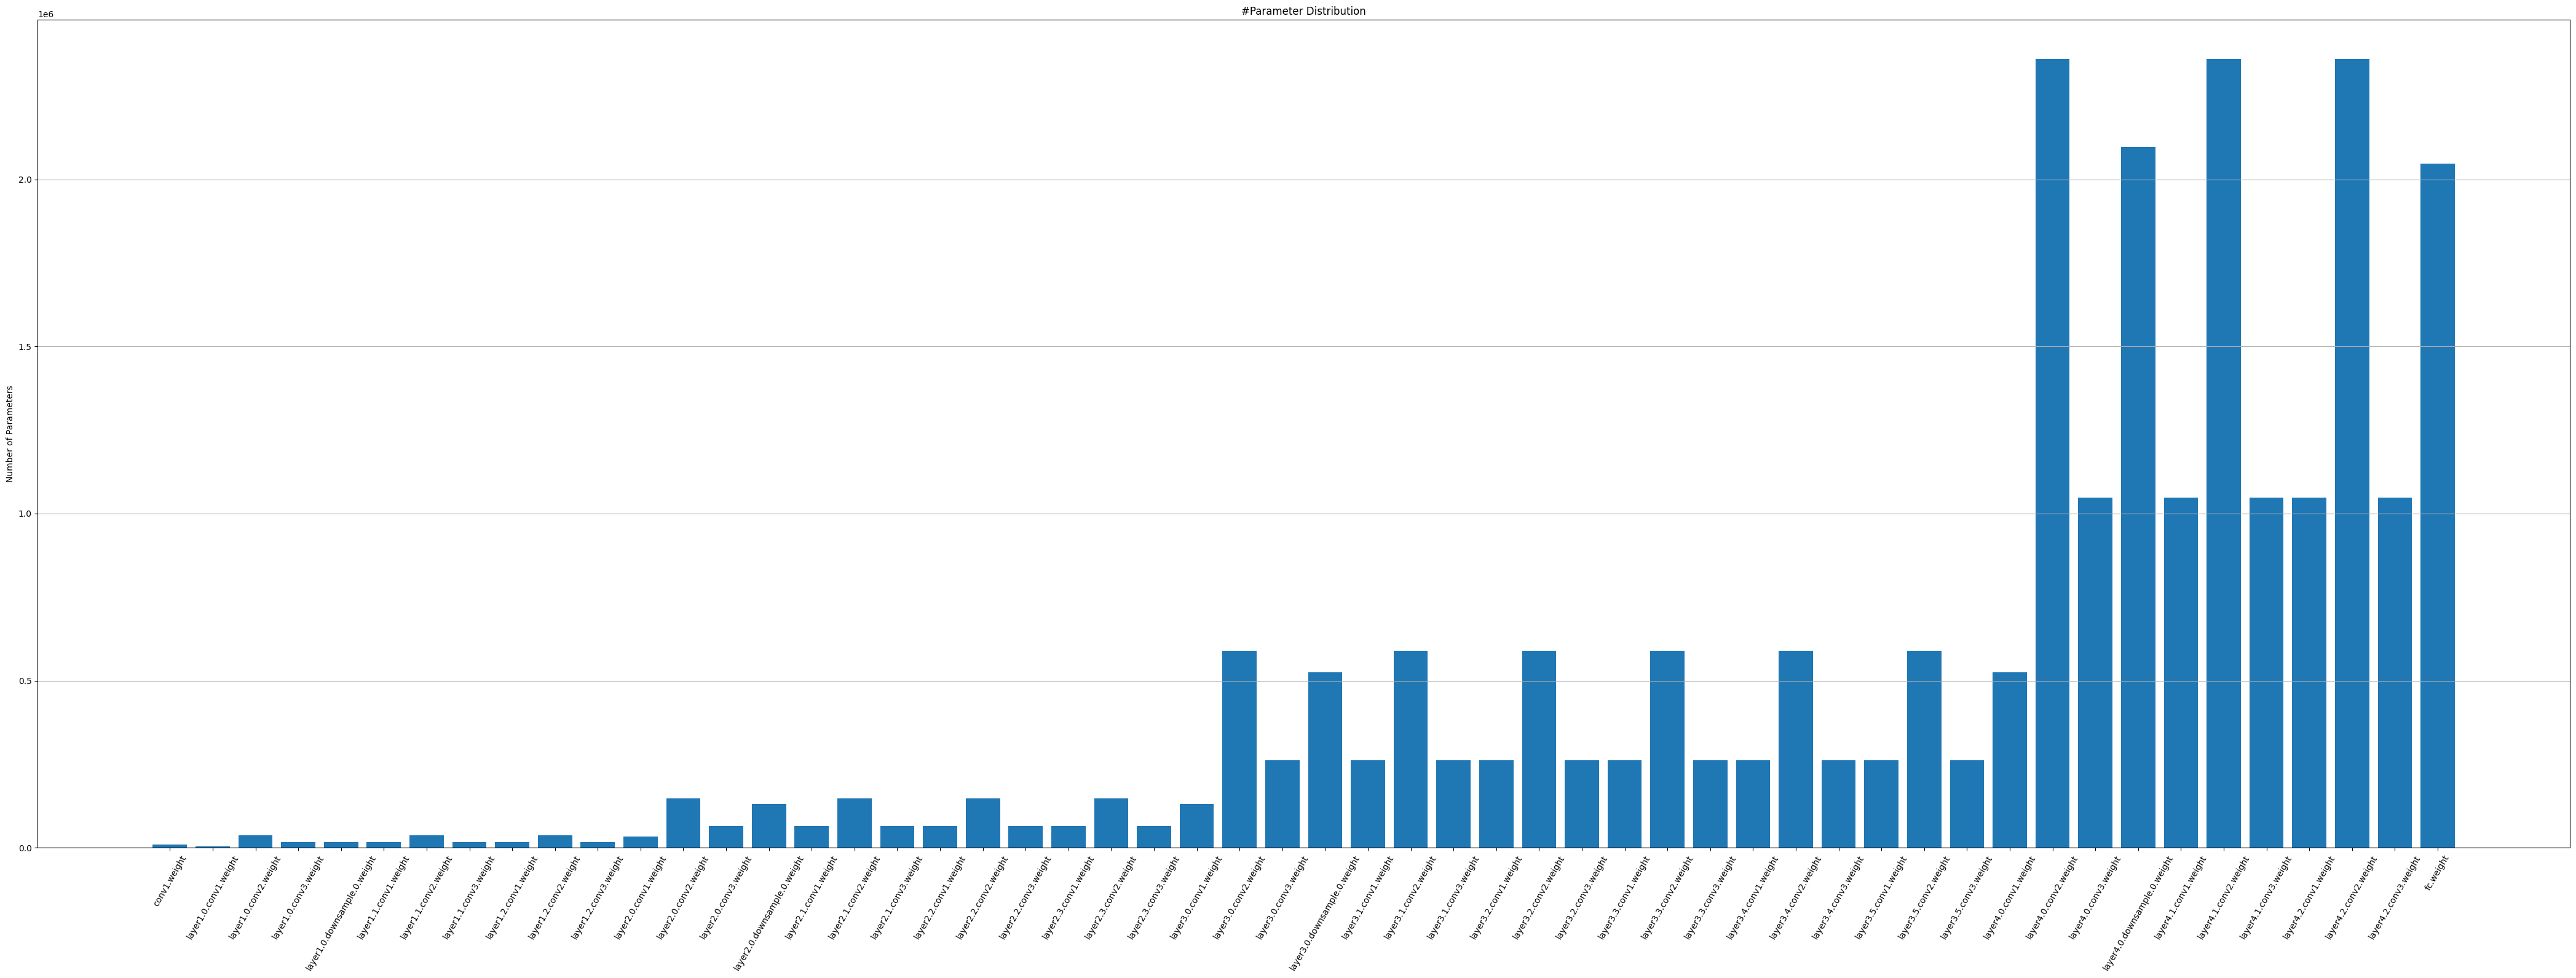

In [15]:
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    print(num_parameters)
    fig = plt.figure(figsize=(42, 16))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()
    
plot_num_parameters_distribution(model)

## Select Sparsity Based on Sensitivity Curves and \#Parameters Distribution



### Question 5 (10 pts)

Based on the sensitivity curves and the distribution of #parameters in the model, please select the sparsity for each layer.

Note that the overall compression ratio of pruned model mostly depends on the layers with larger #parameters, and different layers have different sensitivity to pruning (see Question 4).

Please make sure that after pruning, the sparse model is 25% of the size of the dense model, and validation accuracy is higher than 92.5 after finetuning.

**Hint**:
*   The layer with more #parameters should have larger sparsity. (see *Figure #Parameter Distribution*)
*   The layer that is sensitive to the pruning sparsity (i.e., the accuracy will drop quickly as sparsity becomes higher) should have smaller sparsity. (see *Figure Sensitivity Curves*)

In [15]:
i = 0
sparsity_dict = dict()
for (name, param) in model.named_parameters():
    if param.dim() > 1:
        if i<5:
            sparsity_dict[name] = 0
        else:
            sparsity_dict[name] = 0.5
        i += 1
# sparsity_dict

Please run the following cell to prune the model according to your defined `sparsity_dict`, and print the information of sparse model.

## Finetune the fine-grained pruned model

As we can see from the outputs of previous cell, even though fine-grained pruning reduces the most of model weights, the accuracy of model also dropped. Therefore, we have to finetune the sparse model to recover the accuracy.

Please run the following cell to finetune the sparse model. It should take around 3 minutes to finish.

In [ ]:
# %%capture cap

# model = resnet50(ResNet50_Weights).cuda()
# top1, top5 = evaluate(model, dataloader['val'])
# print("Accuracy before pruning:", top1, top5)
i = 0
x = 2
num_finetune_epochs = 25
optimizer = torch.optim.SGD(model.parameters(), lr=0.007, momentum=0.7, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_sparse_model_checkpoint = dict()
best_accuracy = 0

for i in range(2):
    best_accuracy = 0
    print("Iteration ", i+1)
    # plot_weight_distribution(model, count_nonzero_only=True)
    for key, value in sparsity_dict.items():
        if value == 0:
            sparsity_dict[key] = 0
        else:
            sparsity_dict[key] = 1 - 1/x
    print(f"Compression: {x}x")
    pruner = FineGrainedPruner(model, sparsity_dict)
    sparse_model_size = get_model_size(model, count_nonzero_only=True)
    print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
    top1, top5 = evaluate(model, dataloader['val'])
    print(f"Sparse model has accuracy={top1:.2f}%, {top5:.2f}% before fintuning")
    print(f'Finetuning Fine-grained Pruned Sparse Model')
    for epoch in range(num_finetune_epochs):
        dataloader['train'] = FreshBatchLoader(train_dataset, batch_size=256, max_batches=64)
        train(model, dataloader['train'], criterion, optimizer, scheduler,
            callbacks=[lambda: pruner.apply(model)])
        top1, top5 = evaluate(model, dataloader['val'])
        is_best = top1 > best_accuracy
        if is_best:
            best_sparse_model_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
            torch.save(best_sparse_model_checkpoint['state_dict'] , f'/home/arun/Desktop/Pruning-and-Mixed-Precision-Quantization-of-Neural-Networks/imagenet/pruned/rn50_{x}.pth')
            best_accuracy = top1
        print(f'    Epoch {epoch+1} Accuracy {top1:.2f}% , {top5:.2f}% / Best Accuracy: {best_accuracy:.2f}%')
    x *= 2

Iteration  1
Compression: 2x
Sparse model has size=49.01 MiB = 50.27% of dense model size
Sparse model has accuracy=71.58%, 90.39% before fintuning
Finetuning Fine-grained Pruned Sparse Model


train:   0%|          | 0/64 [00:00<?, ?it/s]

    Epoch 1 Accuracy 75.09% , 92.37% / Best Accuracy: 75.09%


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


    Epoch 2 Accuracy 75.36% , 92.51% / Best Accuracy: 75.36%


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

    Epoch 3 Accuracy 75.35% , 92.56% / Best Accuracy: 75.36%


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

    Epoch 4 Accuracy 75.38% , 92.47% / Best Accuracy: 75.38%


train:   0%|          | 0/64 [00:00<?, ?it/s]

    Epoch 5 Accuracy 75.60% , 92.62% / Best Accuracy: 75.60%


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

    Epoch 6 Accuracy 75.74% , 92.64% / Best Accuracy: 75.74%


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

    Epoch 7 Accuracy 75.58% , 92.64% / Best Accuracy: 75.74%


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

    Epoch 8 Accuracy 75.62% , 92.55% / Best Accuracy: 75.74%


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers

    Traceback (most recent c

    Epoch 9 Accuracy 75.53% , 92.67% / Best Accuracy: 75.74%


train:   0%|          | 0/64 [00:00<?, ?it/s]

    Epoch 10 Accuracy 75.66% , 92.61% / Best Accuracy: 75.74%


train:   0%|          | 0/64 [00:00<?, ?it/s]

    Epoch 11 Accuracy 75.37% , 92.60% / Best Accuracy: 75.74%


train:   0%|          | 0/64 [00:00<?, ?it/s]

    Epoch 12 Accuracy 75.66% , 92.68% / Best Accuracy: 75.74%


train:   0%|          | 0/64 [00:00<?, ?it/s]

    Epoch 13 Accuracy 75.71% , 92.71% / Best Accuracy: 75.74%


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

    Epoch 14 Accuracy 75.66% , 92.69% / Best Accuracy: 75.74%


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

    Epoch 15 Accuracy 75.53% , 92.61% / Best Accuracy: 75.74%


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

    Epoch 16 Accuracy 75.68% , 92.68% / Best Accuracy: 75.74%


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

    Epoch 17 Accuracy 75.67% , 92.78% / Best Accuracy: 75.74%


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

    Epoch 18 Accuracy 75.44% , 92.67% / Best Accuracy: 75.74%


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

    Epoch 19 Accuracy 75.67% , 92.65% / Best Accuracy: 75.74%


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

    Epoch 20 Accuracy 75.80% , 92.61% / Best Accuracy: 75.80%


train:   0%|          | 0/64 [00:00<?, ?it/s]

    Epoch 21 Accuracy 75.53% , 92.60% / Best Accuracy: 75.80%


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

    Epoch 22 Accuracy 75.46% , 92.60% / Best Accuracy: 75.80%


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

    Epoch 23 Accuracy 75.69% , 92.68% / Best Accuracy: 75.80%


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

    Epoch 24 Accuracy 75.67% , 92.73% / Best Accuracy: 75.80%


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

    Epoch 25 Accuracy 75.49% , 92.51% / Best Accuracy: 75.80%
Iteration  2
Compression: 4x
Sparse model has size=24.77 MiB = 25.40% of dense model size


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

Sparse model has accuracy=25.53%, 46.79% before fintuning
Finetuning Fine-grained Pruned Sparse Model


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

    Epoch 1 Accuracy 69.55% , 89.48% / Best Accuracy: 69.55%


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

    Epoch 2 Accuracy 70.43% , 89.98% / Best Accuracy: 70.43%


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


    Epoch 3 Accuracy 70.77% , 90.24% / Best Accuracy: 70.77%


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

    Epoch 4 Accuracy 71.06% , 90.39% / Best Accuracy: 71.06%


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

    Epoch 5 Accuracy 71.35% , 90.59% / Best Accuracy: 71.35%


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


    Epoch 6 Accuracy 71.64% , 90.69% / Best Accuracy: 71.64%


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

    Epoch 7 Accuracy 71.63% , 90.64% / Best Accuracy: 71.64%


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

    Epoch 8 Accuracy 71.73% , 90.60% / Best Accuracy: 71.73%


train:   0%|          | 0/64 [00:00<?, ?it/s]

    Epoch 9 Accuracy 72.01% , 90.83% / Best Accuracy: 72.01%


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

    Epoch 10 Accuracy 72.05% , 90.84% / Best Accuracy: 72.05%


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

    Epoch 11 Accuracy 71.79% , 90.74% / Best Accuracy: 72.05%


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

    Epoch 12 Accuracy 72.07% , 90.89% / Best Accuracy: 72.07%


train:   0%|          | 0/64 [00:00<?, ?it/s]

    Epoch 13 Accuracy 72.31% , 91.09% / Best Accuracy: 72.31%


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

    Epoch 14 Accuracy 72.27% , 91.12% / Best Accuracy: 72.31%


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

    Epoch 15 Accuracy 72.23% , 91.07% / Best Accuracy: 72.31%


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

    Epoch 16 Accuracy 72.46% , 91.18% / Best Accuracy: 72.46%


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

    Epoch 17 Accuracy 72.56% , 91.20% / Best Accuracy: 72.56%


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


    Epoch 18 Accuracy 72.37% , 91.17% / Best Accuracy: 72.56%


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

    Epoch 19 Accuracy 72.55% , 91.32% / Best Accuracy: 72.56%


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

    Epoch 20 Accuracy 72.77% , 91.26% / Best Accuracy: 72.77%


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

    Epoch 21 Accuracy 72.63% , 91.24% / Best Accuracy: 72.77%


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

    Epoch 22 Accuracy 72.54% , 91.26% / Best Accuracy: 72.77%


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

    Epoch 23 Accuracy 72.75% , 91.32% / Best Accuracy: 72.77%


train:   0%|          | 0/64 [00:00<?, ?it/s]

    Epoch 24 Accuracy 72.89% , 91.40% / Best Accuracy: 72.89%


train:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x758373d34310>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

    Epoch 25 Accuracy 72.43% , 91.12% / Best Accuracy: 72.89%


: 

In [ ]:
%cd imagenet/logs/       
with open('rn18_p.txt', 'w') as file:
    file.write(cap.stdout)
%cd ../..

Run the following cell to see the information of best finetuned sparse model.

# Channel Pruning

In this section, we will implement the channel pruning. Channel pruning removes an entire channel, so that it can achieve inference speed up on existing hardware like GPUs. Similarly, we remove the channels whose weights are of smaller magnitudes (measured by Frobenius norm).

In [ ]:
# firstly, let's restore the model weights to the original dense version
#   and check the validation accuracy
model = mobilenet_v3_large(MobileNet_V3_Large_Weights).cuda()
dense_model_accuracy = evaluate(model, dataloader['test'])
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

/usr/lib/python3.10/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/lib/python3.10/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


eval:   0%|          | 0/196 [00:00<?, ?it/s]

dense model has accuracy=74.05%


In [68]:
model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

## Remove Channel Weights

Unlike fine-grained pruning, we can remove the weights entirely from the tensor in channel pruning. That is to say, the number of output channels is reduced:

> $\#\mathrm{out\_channels}_{\mathrm{new}} = \#\mathrm{out\_channels}_{\mathrm{origin}} \cdot (1 - \mathrm{sparsity})$

The weight tensor $W$ is still dense after channel pruning. Thus, we will refer to *sparsity* as ***prune ratio***.

Like fine-grained pruning, we can use different pruning rates for different layers. However, we use a uniform pruning rate for all the layers for now. We are targeting 2x computation reduction, which is roughly 30% uniform pruning rate (think about why).

Feel free to try out different pruning ratios per layer at the end of this section. You can pass in a list of ratios to the `channel_prune` function.

### Question 6 (10 pts)

Please complete the following functions for channel pruning.

Here we naively prune all output channels other than the first $\#\mathrm{out\_channels}_{\mathrm{new}}$ channels.

In [120]:
import torchvision
idx = 0

def get_all_conv_layers(module, conv_layers=None,):
    if conv_layers is None:
        conv_layers = []
        global idx
        idx = 0
    for child in module.children():
        # If the child is a Conv2d layer, add it to the list
        if isinstance(child, nn.Conv2d):
            conv_layers.append(child)
            idx += 1
        elif isinstance(child, nn.BatchNorm2d):
            index_map.append(idx-1)
        else:
            # Recursively search child modules
            get_all_conv_layers(child, conv_layers)
    return conv_layers

def get_all_bn_layers(module, bn_layers=None):
    if bn_layers is None:
        bn_layers = []
    for child in module.children():
        # If the child is a Conv2d layer, add it to the list
        if isinstance(child, nn.BatchNorm2d):
            bn_layers.append(child)
        else:
            # Recursively search child modules
            get_all_bn_layers(child, bn_layers)
    return bn_layers

In [ ]:
def get_num_channels_to_keep(channels: int, prune_ratio: float) -> int:
    """A function to calculate the number of layers to PRESERVE after pruning
    Note that preserve_rate = 1. - prune_ratio
    """
    ##################### YOUR CODE STARTS HERE #####################
    return int(round((1-prune_ratio)*channels))
    ##################### YOUR CODE ENDS HERE #####################
import copy
import torch.nn as nn
from typing import Union, List

def get_all_conv_layers(module):
    """Recursively get all Conv2d layers in model"""
    convs = []
    for _, child in module.named_children():
        if isinstance(child, nn.Conv2d):
            convs.append(child)
        elif len(list(child.children())) > 0:
            convs += get_all_conv_layers(child)
    return convs

def get_corresponding_bn(conv_layer, model):
    """Find BN layer immediately following a Conv layer"""
    parent = None
    # Find parent module containing both Conv and BN
    for name, module in model.named_modules():
        if module is conv_layer:
            parent_name = name.rsplit('.', 1)[0]
            parent = model.get_submodule(parent_name)
            break
    
    if parent:
        # Look for next BN after Conv in parent's children
        found_conv = False
        for child in parent.children():
            if child is conv_layer:
                found_conv = True
                continue
            if found_conv and isinstance(child, nn.BatchNorm2d):
                return child
    return None

def channel_prune_mobilenet(model: nn.Module,
                           prune_ratio: Union[List, float]) -> nn.Module:
    """Working MobileNet v3 pruning with depthwise support"""
    # Get all conv layers recursively
    all_convs = get_all_conv_layers(model)
    n_conv = len(all_convs)
    
    # Validate prune ratios
    if isinstance(prune_ratio, list):
        assert len(prune_ratio) == n_conv - 1
    else:
        prune_ratio = [prune_ratio] * (n_conv - 1)

    model = copy.deepcopy(model)
    
    with torch.no_grad():  # Critical for in-place modifications
        for i_ratio, p_ratio in enumerate(prune_ratio):
            prev_conv = all_convs[i_ratio]
            next_conv = all_convs[i_ratio + 1]
            
            # Get corresponding BN if exists
            prev_bn = get_corresponding_bn(prev_conv, model)
            
            # Calculate preserved channels with group constraints
            original_channels = prev_conv.out_channels
            n_keep = get_num_channels_to_keep(original_channels, p_ratio)
            
            # Adjust for grouped convolutions in NEXT layer
            if next_conv.groups > 1:
                groups = next_conv.groups
                n_keep = max(groups, (n_keep // groups) * groups)
            
            # 1. Prune previous conv OUTPUT
            prev_conv.weight.data = prev_conv.weight.data[:n_keep]
            if prev_conv.bias is not None:
                prev_conv.bias.data = prev_conv.bias.data[:n_keep]
            
            # 2. Prune BN parameters if exists
            if prev_bn:
                prev_bn.weight.data = prev_bn.weight.data[:n_keep]
                prev_bn.bias.data = prev_bn.bias.data[:n_keep]
                prev_bn.running_mean.data = prev_bn.running_mean.data[:n_keep]
                prev_bn.running_var.data = prev_bn.running_var.data[:n_keep]
            
            # 3. Prune next conv INPUT
            if next_conv.groups == 1:
                # Regular conv: slice input channels
                next_conv.weight.data = next_conv.weight.data[:, :n_keep]
            else:
                # Depthwise conv: requires groups == in_channels
                next_conv.groups = n_keep
                # For depthwise: out_channels == in_channels == groups
                next_conv.weight.data = next_conv.weight.data[:n_keep]
                next_conv.in_channels = n_keep
                next_conv.out_channels = n_keep

    return model



Run the following cell to perform a sanity check to make sure the implementation is correct.

In [139]:
dummy_input = torch.randn(1, 3, 32, 32).cuda()
macs = get_model_macs(model, dummy_input)
index_map = []
pruned_model = channel_prune_mobilenet(model, prune_ratio=0.2)
print(index_map)
pruned_macs = get_model_macs(pruned_model, dummy_input)
macs, pruned_macs
# assert pruned_macs == 305388064
# print('* Check passed. Right MACs for the pruned model.')

RuntimeError: Given groups=16, expected weight to be at least 16 at dimension 0, but got weight of size [13, 1, 3, 3] instead

Now let's evaluate the performance of the model after uniform channel pruning with 30% pruning rate.

As you may see, directly removing 30% of the channels leads to low accuracy.

In [71]:
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")

eval:   0%|          | 0/196 [00:00<?, ?it/s]

pruned model has accuracy=74.05%


## Ranking Channels by Importance

As you can see, removing the first 30% of channels in all layers leads to significant accuracy reduction. One potential method to remedy the issue is to find the **less important** channel weights to remove. A popular criterion for importance is to use the Frobenius norm of the weights corresponding to each input channel:

> $importance_{i} = \|W_{i}\|_2, \;\; i = 0, 1, 2,\cdots, \#\mathrm{in\_channels}-1$

We can sort the channel weights from more important to less important, and then keep the frst $k$ channels for each layer.

### Question 7 (15 pts)
Please complete the following functions for sorting the weight tensor based on the Frobenius norm.

**Hint**:
* To calculate Frobenius norm of a tensor, Pytorch provides [`torch.norm`](https://pytorch.org/docs/master/generated/torch.norm.html?highlight=torch+norm#torch.norm) APIs.

In [126]:
# function to sort the channels from important to non-important
def get_input_channel_importance(weight):
    in_channels = weight.shape[1]
    importances = []
    # compute the importance for each input channel
    for i_c in range(weight.shape[1]):
        channel_weight = weight.detach()[:, i_c]
        ##################### YOUR CODE STARTS HERE #####################
        importance = torch.norm(channel_weight, p=2)
        ##################### YOUR CODE ENDS HERE #####################
        importances.append(importance.view(1))
    return torch.cat(importances)

@torch.no_grad()
def apply_channel_sorting(model):
    model = copy.deepcopy(model)  # do not modify the original model
    # fetch all the conv and bn layers from the features
    all_convs = [m for m in model.features if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.features if isinstance(m, nn.BatchNorm2d)]
    # iterate through conv layers
    for i_conv in range(len(all_convs) - 1):
        # each channel sorting index, we need to apply it to:
        # - the output dimension of the previous conv
        # - the previous BN layer
        # - the input dimension of the next conv (we compute importance here)
        prev_conv = all_convs[i_conv]
        prev_bn = all_bns[i_conv]
        next_conv = all_convs[i_conv + 1]
        # note that we always compute the importance according to input channels
        importance = get_input_channel_importance(next_conv.weight)
        # sorting from large to small
        sort_idx = torch.argsort(importance, descending=True)

        # apply to previous conv and its following bn
        prev_conv.weight.copy_(torch.index_select(
            prev_conv.weight.detach(), 0, sort_idx))
        for tensor_name in ['weight', 'bias', 'running_mean', 'running_var']:
            tensor_to_apply = getattr(prev_bn, tensor_name)
            tensor_to_apply.copy_(
                torch.index_select(tensor_to_apply.detach(), 0, sort_idx)
            )

        # apply to the next conv input (hint: one line of code)
        ##################### YOUR CODE STARTS HERE #####################
        next_conv.weight.copy_(torch.index_select(next_conv.weight.detach(), 1, sort_idx))
        ##################### YOUR CODE ENDS HERE #####################

    return model

Now run the following cell to sanity check if the results are correct.

In [127]:
# print('Before sorting...')
# dense_model_accuracy = evaluate(model, dataloader['test'])
# print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

print('After sorting...')
sorted_model = apply_channel_sorting(model)
sorted_model_accuracy = evaluate(sorted_model, dataloader['test'])
print(f"sorted model has accuracy={sorted_model_accuracy:.2f}%")

# make sure accuracy does not change after sorting, since it is
# equivalent transform
assert abs(sorted_model_accuracy - dense_model_accuracy) < 0.1
print('* Check passed.')

After sorting...


eval:   0%|          | 0/196 [00:00<?, ?it/s]

sorted model has accuracy=74.05%
* Check passed.


Finally, we compare the pruned models' accuracy with and without sorting.

In [53]:
channel_pruning_ratio = 0.3  # pruned-out ratio

print(" * Without sorting...")
pruned_model = channel_prune(model, channel_pruning_ratio)
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")


print(" * With sorting...")
sorted_model = apply_channel_sorting(model)
pruned_model = channel_prune(sorted_model, channel_pruning_ratio)
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")


 * Without sorting...
MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1,

eval:   0%|          | 0/196 [00:00<?, ?it/s]

pruned model has accuracy=74.05%
 * With sorting...
MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): 

eval:   0%|          | 0/196 [00:00<?, ?it/s]

pruned model has accuracy=74.05%


As you can see, the channel sorting can slightly improve the pruned model's accuracy, but there is still a huge degrade, which is quite common for channel pruning. But luckily, we can perform fine-tuning to recover the accuracy.

In [54]:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(pruned_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_accuracy = 0
for epoch in range(num_finetune_epochs):
    train(pruned_model, dataloader['train'], criterion, optimizer, scheduler)
    accuracy = evaluate(pruned_model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_accuracy = accuracy
    print(f'Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

train:   0%|          | 0/5005 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x775868d004c0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


eval:   0%|          | 0/196 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x775868d004c0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x775868d004c0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

Epoch 1 Accuracy 73.04% / Best Accuracy: 73.04%


train:   0%|          | 0/5005 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x775868d004c0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x775868d004c0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

eval:   0%|          | 0/196 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x775868d004c0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x775868d004c0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

Epoch 2 Accuracy 73.10% / Best Accuracy: 73.10%


train:   0%|          | 0/5005 [00:00<?, ?it/s]

eval:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3 Accuracy 71.99% / Best Accuracy: 73.10%


train:   0%|          | 0/5005 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x775868d004c0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x775868d004c0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

eval:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4 Accuracy 72.66% / Best Accuracy: 73.10%


train:   0%|          | 0/5005 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x775868d004c0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x775868d004c0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

eval:   0%|          | 0/196 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x775868d004c0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x775868d004c0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._p

Epoch 5 Accuracy 72.56% / Best Accuracy: 73.10%


## Measure acceleration from pruning

After fine-tuning, the model almost recovers the accuracy. You may have already learned that channel pruning is usually more difficult to recover accuracy compared to fine-grained pruning. However, it directly leads to a smaller model size and smaller computation without specialized model format. It can also run faster on GPUs. Now we compare the model size, computation, and latency of the pruned model.

In [56]:
# helper functions to measure latency of a regular PyTorch models.
#   Unlike fine-grained pruning, channel pruning
#   can directly leads to model size reduction and speed up.
@torch.no_grad()
def measure_latency(model, dummy_input, n_warmup=20, n_test=100):
    model.eval()
    # warmup
    for _ in range(n_warmup):
        _ = model(dummy_input)
    # real test
    t1 = time.time()
    for _ in range(n_test):
        _ = model(dummy_input)
    t2 = time.time()
    return (t2 - t1) / n_test  # average latency

table_template = "{:<15} {:<15} {:<15} {:<15}"
print (table_template.format('', 'Original','Pruned','Reduction Ratio'))

# 1. measure the latency of the original model and the pruned model on CPU
#   which simulates inference on an edge device
dummy_input = torch.randn(1, 3, 32, 32).to('cpu')
pruned_model = pruned_model.to('cpu')
model = model.to('cpu')

pruned_latency = measure_latency(pruned_model, dummy_input)
original_latency = measure_latency(model, dummy_input)
print(table_template.format('Latency (ms)',
                            round(original_latency * 1000, 1),
                            round(pruned_latency * 1000, 1),
                            round(original_latency / pruned_latency, 1)))

# 2. measure the computation (MACs)
original_macs = get_model_macs(model, dummy_input)
pruned_macs = get_model_macs(pruned_model, dummy_input)
print(table_template.format('MACs (M)',
                            round(original_macs / 1e6),
                            round(pruned_macs / 1e6),
                            round(original_macs / pruned_macs, 1)))

# 3. measure the model size (params)
original_param = get_num_parameters(model)
pruned_param = get_num_parameters(pruned_model)
print(table_template.format('Param (M)',
                            round(original_param / 1e6, 2),
                            round(pruned_param / 1e6, 2),
                            round(original_param / pruned_param, 1)))

# put model back to cuda
pruned_model = pruned_model.to('cuda')
model = model.to('cuda')

                Original        Pruned          Reduction Ratio
Latency (ms)    4.7             4.6             1.0            
MACs (M)        8               8               1.0            
Param (M)       5.48            5.48            1.0            


/home/arun/.local/lib/python3.10/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::hardswish_". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/arun/.local/lib/python3.10/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::hardsigmoid". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/arun/.local/lib/python3.10/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::hardswish_". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/arun/.local/lib/python3.10/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::hardsigmoid". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(


### Question 8 (10 pts)

Please answer the following questions using the information in the previous code cell.


#### Question 8.1 (5 pts)

Explain why removing 30% of channels roughly leads to 50% computation reduction.

**Your Answer:** (1 - 30%)^2 = 0.49

#### Question 8.2 (5 pts)

Explain why the latency reduction ratio is slightly smaller than computation reduction.

**Your Answer:** Computation reduction != latency reduction. We should consider data movement as well.

# Compare Fine-grained Pruning and Channel Pruning


## Question 9 (10 pts)


After all experiments in this lab, you may have become familiar with both fine-grained pruning and channel pruning.

Please answer the following questions using what you have learned from the lectures and this lab.

### Question 9.1 (5 pts)

What are the advantages and disadvantages of fine-grained pruning and channel pruning? You can discuss from the perspective of compression ratio, accuracy, latency, hardware support (*i.e.*, requiring specialized hardware accelerator), etc.

**Your Answer:**

### Fine-grained pruning
#### Pros
- Performance
- Fine-grained

#### Cons
- Require specific hardware design

### Channel Pruning
#### Pros
- Not require specific hardware

#### Cons
- Performance is worse than Fine-grained pruning

### Question 9.2 (5 pts)

If you want to make your model run faster on a smartphone, which pruning method will you use? Why?

**Your Answer:** Channel Pruning

# Feedback

Please fill out this [feedback form](https://forms.gle/fapEmEUYr3WnXjBU8) when you finished this lab. We would love to hear your thoughts or feedback on how we can improve this lab!